In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)

# reload all changed moduels
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [788]:
from my_data import MyData
from my_collate import MyCollate
from my_embedding import MyEmbedding
from my_process import MyProcess
from my_parser import MyParser
from my_rnn import RNN

##  classify top 3 miRNAs from other miRNAs

In [40]:
# prepare dataset
infile = 'mature.fa'
# infile = 'hairpin.fa'

md = MyData(infile)
train_data = md.get_data()
print('Number of data:', len(train_data))
print('Observe data:', train_data[0])

top_species = md.top_species()

Number of data: 48885
Observe data: ('Caenorhabditis elegans', 'UGAGGUAGUAGGUUGUAUAGUU')
	 Homo sapiens 2656
	 Mus musculus 1978
	 Gallus gallus 1235


In [91]:
# embedding
me = MyEmbedding(train_data)
train_dataset, valid_dataset = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

for s in top_species+ ['<pad>', '<unk>']:
    print(s, label_vocab[s])


('Oryza sativa', 'CGAGGACGAGAUACAGUGCAG')
39108 <class 'torch.utils.data.dataset.Subset'>

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: GAGUUCCCUGCACUCCAAGUC ['G', 'A', 'G', 'U', 'U', 'C', 'C', 'C', 'U', 'G', 'C', 'A', 'C', 'U', 'C', 'C', 'A', 'A', 'G', 'U', 'C']
Vocab-size of input: 4
Vocab-size of labels: 263
OrderedDict([('U', 243538), ('G', 218558), ('A', 205144), ('C', 187079)])
counts of input: [2123, 1576, 989, 919, 822, 715, 613, 608, 607, 589, 563, 541, 538, 524, 516, 505, 485, 480, 477, 475, 468, 459, 455, 423, 419, 416, 398, 383, 379, 367, 366, 363, 360, 347, 344, 343, 341, 340, 323, 320, 313, 307, 307, 305, 304, 296, 284, 277, 260, 258, 258, 256, 252, 246, 242, 242, 241, 220, 211, 202, 199, 197, 186, 184, 182, 177, 177, 171, 170, 169, 166, 164, 160, 159, 157, 156, 153, 153, 148, 145, 144, 142, 139, 138, 136, 133, 133, 132, 132, 130, 129, 126, 126, 124, 122, 121, 119, 117, 116, 114, 114, 110, 107, 105, 105, 103, 102, 102, 101, 101, 98, 97,

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(input_vocab)
embed_dim = 24
rnn_hidden_size = 32
fc_hidden_size = 32


model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)
model.to

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: label_vocab[x] if x in top_species else 1
collate_fn = MyCollate(text_pipeline, label_pipeline)

num_epochs = 5
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_dataset, valid_dataset)

Epoch 0 accuracy: 0.8763 val_accuracy: 0.8772
Epoch 1 accuracy: 0.8806 val_accuracy: 0.8772
Epoch 2 accuracy: 0.8806 val_accuracy: 0.8772
Epoch 3 accuracy: 0.8806 val_accuracy: 0.8772
Epoch 4 accuracy: 0.8806 val_accuracy: 0.8772


In [60]:
print(trained_model.embedding)
trained_model.embedding.weight 

Embedding(6, 24, padding_idx=0)


Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0811,  1.5823, -1.7560, -1.0417, -0.7123, -1.2777, -0.0544, -1.1841,
          1.4256,  2.4228, -0.5427,  0.5291, -1.4635, -1.3259,  1.8546, -0.1015,
         -0.1857, -0.4170, -0.1141,  1.5126,  1.5629, -0.3201,  0.4258, -0.9879],
        [-0.2306,  1.7994, -2.3559,  0.4955,  0.4464, -0.0609,  0.5692,  0.1316,
          0.3352,  0.5976, -1.5176,  0.5934,  0.1986,  0.6710, -1.1153, -0.0967,
          0.5486, -0.0611, -0.0323, -0.2777,  0.0151,  0.7522, -2.0103,  1.0629],
        [ 1.1543,  0.5715,  0.9824,  1.2455,  1.0591,  0.2686,  0.4754, -0.4993,
          0.4265, -0.2658,  1.2396, -2.6436,  0.8240, -1.9936,  0.7860, -1.9972,
         -0.7333,  0.0879, -0.3458, -1.0506,  0.1257,  0.0636, -0.3167,  0.0244],
  

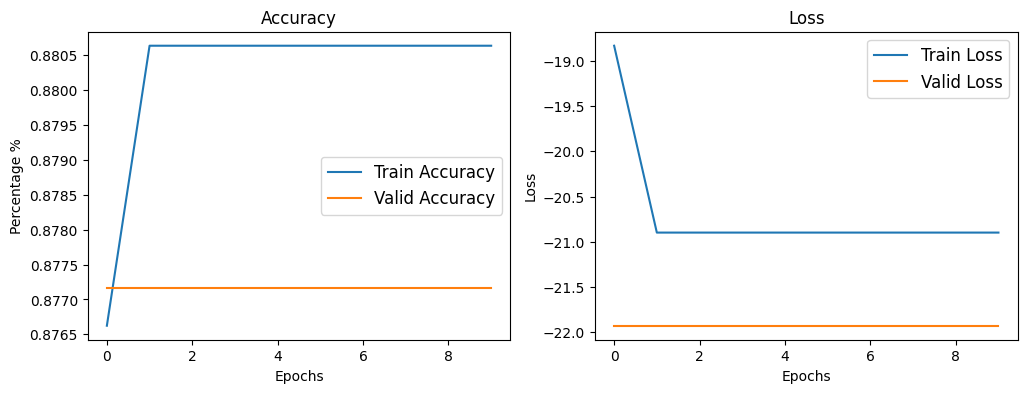

,acc_train,loss_train,acc_valid,loss_valid
0,0.876624,-18.831038,0.877161,-21.929017
1,0.880638,-20.898537,0.877161,-21.929017
2,0.880638,-20.898537,0.877161,-21.929017
3,0.880638,-20.898537,0.877161,-21.929017
4,0.880638,-20.898537,0.877161,-21.929017
5,0.880638,-20.898537,0.877161,-21.929017
6,0.880638,-20.898537,0.877161,-21.929017
7,0.880638,-20.898537,0.877161,-21.929017
8,0.880638,-20.898537,0.877161,-21.929017
9,0.880638,-20.898537,0.877161,-21.929017


In [88]:
fig = plt.figure(figsize=(12,4))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Train Accuracy")
ax.plot(x_arr, stat.acc_valid, label="Valid Accuracy")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Train Loss")
ax.plot(x_arr, stat.loss_valid, label="Valid Loss")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()
stat

##  classify human miRNA from other miRNAs

In [92]:
# prepare dataset
infile = 'mature.fa'
# infile = 'hairpin.fa'

md = MyData(infile)
train_data = md.get_data()
print('Number of data:', len(train_data))
print('Observe data:', train_data[0])

Number of data: 48885
Observe data: ('Caenorhabditis elegans', 'UGAGGUAGUAGGUUGUAUAGUU')


In [93]:
# embedding
me = MyEmbedding(train_data)
train_dataset, valid_dataset = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

('Anolis carolinensis', 'CCCAAGUAGGUUGAUGUCUGG')
39108 <class 'torch.utils.data.dataset.Subset'>

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: UGAUUGAGCCGUGCCAAUAUC ['U', 'G', 'A', 'U', 'U', 'G', 'A', 'G', 'C', 'C', 'G', 'U', 'G', 'C', 'C', 'A', 'A', 'U', 'A', 'U', 'C']
Vocab-size of input: 4
Vocab-size of labels: 264
OrderedDict([('U', 243733), ('G', 218618), ('A', 205513), ('C', 186602)])
counts of input: [2100, 1567, 989, 914, 816, 752, 604, 600, 592, 588, 558, 551, 528, 520, 518, 498, 483, 482, 478, 471, 463, 458, 437, 433, 431, 402, 399, 382, 377, 370, 369, 368, 367, 349, 348, 348, 341, 329, 328, 325, 316, 314, 300, 295, 293, 283, 279, 279, 274, 268, 259, 258, 257, 255, 245, 244, 231, 213, 209, 204, 203, 197, 197, 189, 186, 180, 179, 177, 168, 167, 166, 162, 161, 155, 151, 150, 150, 149, 147, 147, 145, 144, 142, 139, 138, 136, 136, 136, 134, 132, 129, 129, 125, 124, 124, 124, 124, 120, 119, 117, 115, 112, 110, 110, 108, 105, 100, 100, 99, 98, 96

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(input_vocab)
embed_dim = 24
rnn_hidden_size = 32
fc_hidden_size = 32


model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)
model.to

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'Homo sapiens' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

num_epochs = 50
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_dataset, valid_dataset)

Epoch 0 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 1 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 2 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 3 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 4 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 5 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 6 accuracy: 0.9464 val_accuracy: 0.9431
Epoch 7 accuracy: 0.9463 val_accuracy: 0.9431
Epoch 8 accuracy: 0.9464 val_accuracy: 0.9429
Epoch 9 accuracy: 0.9464 val_accuracy: 0.9434
Epoch 10 accuracy: 0.9461 val_accuracy: 0.9432
Epoch 11 accuracy: 0.9464 val_accuracy: 0.9437
Epoch 12 accuracy: 0.9466 val_accuracy: 0.9438
Epoch 13 accuracy: 0.9464 val_accuracy: 0.9436
Epoch 14 accuracy: 0.9464 val_accuracy: 0.9434
Epoch 15 accuracy: 0.9465 val_accuracy: 0.9444
Epoch 16 accuracy: 0.9467 val_accuracy: 0.9435
Epoch 17 accuracy: 0.9467 val_accuracy: 0.9433
Epoch 18 accuracy: 0.9467 val_accuracy: 0.9436
Epoch 19 accuracy: 0.9468 val_accuracy: 0.9436
Epoch 20 accuracy: 0.9474 val_accuracy: 0.9428
Epoch 21 accuracy: 0.94

In [98]:
print(trained_model.embedding)
trained_model.embedding.weight 

Embedding(6, 24, padding_idx=0)


Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5080, -0.8930,  0.1894, -1.1677,  0.7664,  0.8891, -1.1316, -0.1869,
         -1.5971, -1.3680, -1.0689,  0.6165,  0.9048, -0.6676,  0.4762, -0.2062,
         -0.2433, -0.1421, -1.2874,  0.7884, -0.2169, -0.9074,  1.1873, -0.7823],
        [-0.3048, -0.0871, -2.6071, -0.6547,  0.7909,  0.8218, -0.3377,  0.1318,
          0.2611, -0.8266,  0.1100, -0.3484,  0.4189,  0.1719,  0.7797,  0.6859,
         -0.2590,  2.1169,  0.1054, -0.2098,  1.2131, -0.5103,  0.2274,  0.4670],
        [-0.3012,  0.3303,  0.5008,  0.1392, -0.4523, -0.0897, -0.9021, -0.2236,
          0.3653,  0.2925, -0.2538,  0.1669, -0.2754, -0.0272,  0.2038,  0.1620,
          0.3491,  1.0248, -0.0870, -0.1883, -1.8301, -1.3517, -2.5999, -0.3160],
  

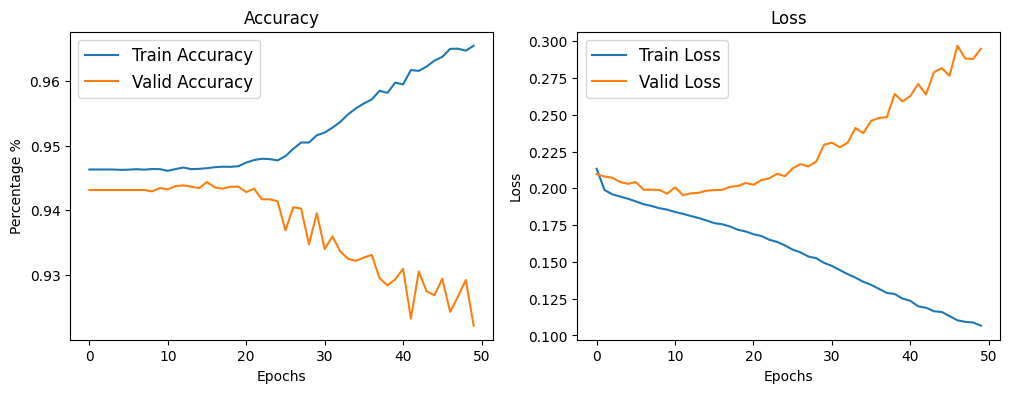

In [100]:
fig = plt.figure(figsize=(12,4))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Train Accuracy")
ax.plot(x_arr, stat.acc_valid, label="Valid Accuracy")
ax.legend(fontsize=12)
# ax.set_ylim(.8, 1)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Train Loss")
ax.plot(x_arr, stat.loss_valid, label="Valid Loss")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

##  full dataset: detect miRNAs
positive: full length miRNAs, trimmed miRNAs
negative: shuffled seq, random seq

In [757]:
# prepare dataset
md = MyData()
train_data = md.get_full_data()
print('Total number of data:', len(train_data))
print('Observe data:', train_data[0])

Number of origin seq: 48882
Number of trim seq: 683174
Number of shuffle seq: 48882
Number of 5srrnadb.fasta: 11415
Number of gtrnadb.fasta: 236835
Number of pirbase.fasta: 219278
Total number of data: 1146682
Observe data: ('Caenorhabditis elegans', 'TGAGGTAGTAGGTTGTATAGTT')


In [758]:
# embedding
me = MyEmbedding(train_data)
train_dataset, valid_dataset = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

('Populus trichocarpa', 'GAGAAGCAGGGCACGTGCA')
917346 <class 'torch.utils.data.dataset.Subset'>

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: ACTCTAAATTTTAAATTC ['A', 'C', 'T', 'C', 'T', 'A', 'A', 'A', 'T', 'T', 'T', 'T', 'A', 'A', 'A', 'T', 'T', 'C']
Vocab-size of input: 14
Vocab-size of labels: 268
OrderedDict([('G', 8653969), ('T', 7697766), ('C', 7401751), ('A', 6710983), ('N', 42288), ('Y', 75), ('R', 34), ('S', 20), ('W', 17), ('K', 17), ('M', 16), ('D', 2), ('B', 1), ('X', 1)])
counts of input: [253625, 39161, 39141, 29932, 24157, 15584, 13891, 11631, 11189, 10388, 9209, 8968, 8908, 8903, 8693, 8362, 8342, 8072, 8023, 7836, 7832, 7630, 7608, 7316, 6942, 6841, 6637, 6400, 6385, 6292, 6288, 6080, 5939, 5602, 5349, 5286, 5220, 5056, 4954, 4781, 4695, 4660, 4650, 4499, 4474, 4399, 4329, 4222, 4203, 4078, 3970, 3961, 3954, 3897, 3685, 3576, 3533, 3385, 3344, 3307, 3287, 3159, 3002, 2971, 2961, 2759, 2699, 2639, 2638, 2595, 2545, 2513, 2457, 2453, 2

In [760]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(input_vocab)
embed_dim = 24
rnn_hidden_size = 32
fc_hidden_size = 32

model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)
model.to

# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 0. if x in('random', 'shuffle', 'other') else 1.
collate_fn = MyCollate(text_pipeline, label_pipeline)

# training model
num_epochs = 50
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_dataset, valid_dataset)

Epoch 0 acc: 0.9556 val_acc: 0.9590, val_recall: 0.9399
Epoch 1 acc: 0.9590 val_acc: 0.9597, val_recall: 0.9393
Epoch 2 acc: 0.9601 val_acc: 0.9595, val_recall: 0.9473
Epoch 3 acc: 0.9608 val_acc: 0.9617, val_recall: 0.9443
Epoch 4 acc: 0.9614 val_acc: 0.9615, val_recall: 0.9474
Epoch 5 acc: 0.9615 val_acc: 0.9617, val_recall: 0.9445
Epoch 6 acc: 0.9623 val_acc: 0.9624, val_recall: 0.9481
Epoch 7 acc: 0.9627 val_acc: 0.9626, val_recall: 0.9502
Epoch 8 acc: 0.9631 val_acc: 0.9629, val_recall: 0.9470
Epoch 9 acc: 0.9603 val_acc: 0.9606, val_recall: 0.9482
Epoch 10 acc: 0.9631 val_acc: 0.9638, val_recall: 0.9492
Epoch 11 acc: 0.9640 val_acc: 0.9633, val_recall: 0.9510
Epoch 12 acc: 0.9642 val_acc: 0.9640, val_recall: 0.9477
Epoch 13 acc: 0.9646 val_acc: 0.9637, val_recall: 0.9487
Epoch 14 acc: 0.9648 val_acc: 0.9634, val_recall: 0.9470
Epoch 15 acc: 0.9652 val_acc: 0.9645, val_recall: 0.9515
Epoch 16 acc: 0.9653 val_acc: 0.9642, val_recall: 0.9488
Epoch 17 acc: 0.9656 val_acc: 0.9645, val

In [761]:
# test model using origin only dataset
_data = md.get_origin_data()
me1 = MyEmbedding(_data)
_dataset = me1.split2()

p = MyProcess(model, collate_fn)
p.test({'origin': _dataset})

Number of origin seq: 48882
('Homo sapiens', 'TCTGGCTCCGTGTCTTCACTCCC')
48881 <class 'torch.utils.data.dataset.Subset'>
dataset: origin, accuracy: 0.9334, loss: 0.1945, recall: 0.9334


,acc,loss,recall
origin,0.93341,0.194521,0.93341


In [762]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.955607,0.116797,0.959016,0.102660,0.939940
1,0.958953,0.105042,0.959723,0.100222,0.939314
2,0.960059,0.101764,0.959509,0.106034,0.947328
3,0.960771,0.099778,0.961663,0.096358,0.944268
4,0.961384,0.097840,0.961493,0.095371,0.947419
5,0.961506,0.097269,0.961707,0.096872,0.944509
6,0.962308,0.094978,0.962413,0.095360,0.948120
7,0.962746,0.093816,0.962592,0.093101,0.950166
8,0.963126,0.092550,0.962915,0.092894,0.946952
9,0.960331,0.101036,0.960591,0.099699,0.948249


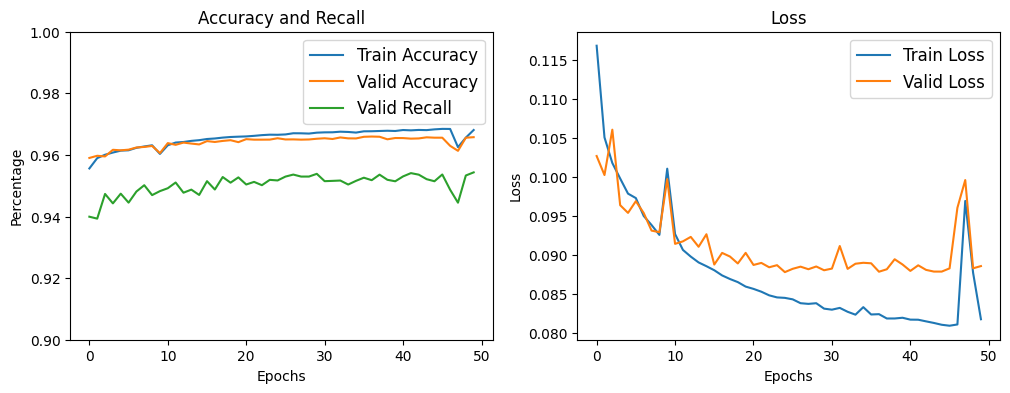

In [768]:
fig = plt.figure(figsize=(12,4))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Train Accuracy")
ax.plot(x_arr, stat.acc_valid, label="Valid Accuracy")
ax.plot(x_arr, stat.rec_valid, label="Valid Recall")
ax.legend(fontsize=12)
ax.set_ylim(.9, 1)
ax.set_title('Accuracy and Recall')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Train Loss")
ax.plot(x_arr, stat.loss_valid, label="Valid Loss")
ax.legend(fontsize=12)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [769]:
# test model using full train_dataset
me1 = MyEmbedding(train_data)
full_dataset = me1.split2()

p = MyProcess(model, collate_fn)
stat = p.test({'full': full_dataset})

('Melibe leonina', 'AAGCATTGGAAAAGCTGAAC')
1146681 <class 'torch.utils.data.dataset.Subset'>
dataset: full, accuracy: 0.9684, loss: 0.0815, recall: 0.9575


In [772]:
#test model using trimed seq data
md2 = MyData()
trim_dataset = md2.get_trim_data()

p = MyProcess(model, collate_fn)
trim_stat = p.test(trim_dataset)

Number of trim seq: 683168
dataset: 18, accuracy: 1.0000, loss: 0.0022, recall: 1.0000
dataset: 19, accuracy: 1.0000, loss: 0.0069, recall: 1.0000
dataset: 20, accuracy: 0.9985, loss: 0.0322, recall: 0.9985
dataset: 21, accuracy: 0.9758, loss: 0.1220, recall: 0.9758
dataset: 22, accuracy: 0.9110, loss: 0.2418, recall: 0.9110
dataset: 23, accuracy: 0.8805, loss: 0.3012, recall: 0.8805
dataset: 24, accuracy: 0.9052, loss: 0.2619, recall: 0.9052
dataset: 25, accuracy: 0.9328, loss: 0.2202, recall: 0.9328
dataset: 26, accuracy: 0.9448, loss: 0.1734, recall: 0.9448
dataset: 27, accuracy: 0.9394, loss: 0.1805, recall: 0.9394
dataset: 28, accuracy: 0.9111, loss: 0.4518, recall: 0.9111


In [ ]:
trim_stat

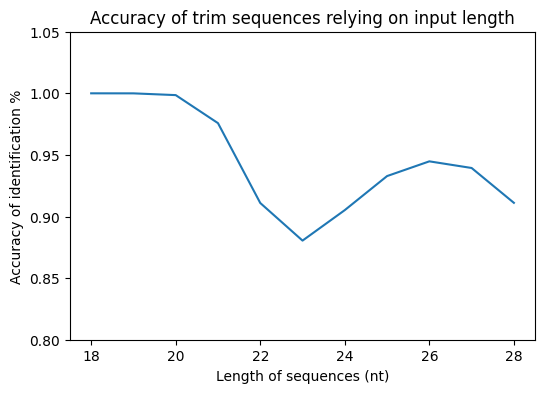

In [775]:
fig = plt.figure(figsize=(6,4))
x_arr = list(trim_stat.index)
ax = fig.add_subplot(1,1,1)
ax.plot(x_arr, trim_stat.acc, label="Accuracy")
ax.set_ylim(.8, 1.05)
ax.set_title('Accuracy of trim sequences relying on input length')
ax.set_xlabel('Length of sequences (nt)')
ax.set_ylabel('Accuracy of identification %')
plt.show()

In [776]:
#test model using random seq data
md2 = MyData()
random_dataset = md2.get_random_data()

p = MyProcess(model, collate_fn)
random_stat = p.test(random_dataset)

Number of trim seq: 900000
dataset: 20, accuracy: 0.0352, loss: 2.9057, recall: 0.0352
dataset: 21, accuracy: 0.2569, loss: 1.4951, recall: 0.2569
dataset: 22, accuracy: 0.5120, loss: 0.9208, recall: 0.5120
dataset: 23, accuracy: 0.5871, loss: 0.7692, recall: 0.5871
dataset: 24, accuracy: 0.6350, loss: 0.6981, recall: 0.6350
dataset: 25, accuracy: 0.6521, loss: 0.6693, recall: 0.6521
dataset: 26, accuracy: 0.6961, loss: 0.5930, recall: 0.6961
dataset: 27, accuracy: 0.8244, loss: 0.3448, recall: 0.8244
dataset: 28, accuracy: 0.9624, loss: 0.0838, recall: 0.9624


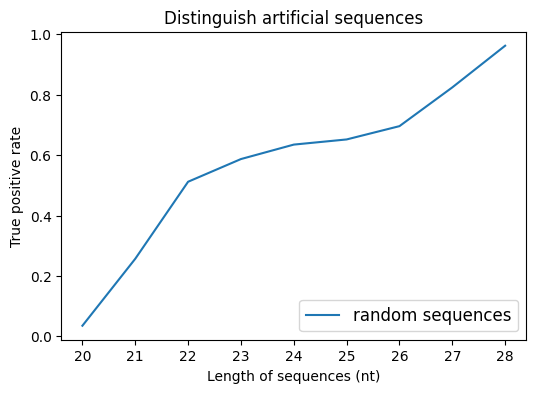

In [779]:
fig = plt.figure(figsize=(6,4))
x_arr = list(random_stat.index)
ax = fig.add_subplot(1,1,1)
ax.plot(x_arr, random_stat.acc, label="random sequences")
# ax.set_ylim(.9, 1.05)
ax.legend(fontsize=12, loc='lower right')
ax.set_title('Distinguish artificial sequences')
ax.set_xlabel('Length of sequences (nt)')
ax.set_ylabel('True positive rate')
plt.show()

In [780]:
#test model using mutation miRNAs data
mutation_dataset = {}
md2 = MyData()
for n in range(1,11):
    mutation_dataset[n] = md.get_mutation_data(n)
print(mutation_dataset)


p = MyProcess(model, collate_fn)
mutation_stat = p.test(mutation_dataset)

{1: <my_dataset.MyDataset object at 0x79fd063bdd30>, 2: <my_dataset.MyDataset object at 0x79fd688c0400>, 3: <my_dataset.MyDataset object at 0x79fee0935970>, 4: <my_dataset.MyDataset object at 0x79fd83953ca0>, 5: <my_dataset.MyDataset object at 0x79fd83953940>, 6: <my_dataset.MyDataset object at 0x79fdd1b8c6d0>, 7: <my_dataset.MyDataset object at 0x79fdba3a3850>, 8: <my_dataset.MyDataset object at 0x79fd27b49cd0>, 9: <my_dataset.MyDataset object at 0x79fd03d1c490>, 10: <my_dataset.MyDataset object at 0x79fd83953910>}
dataset: 1, accuracy: 0.9026, loss: 0.2557, recall: 0.9026
dataset: 2, accuracy: 0.8778, loss: 0.3024, recall: 0.8778
dataset: 3, accuracy: 0.8624, loss: 0.3364, recall: 0.8624
dataset: 4, accuracy: 0.8483, loss: 0.3644, recall: 0.8483
dataset: 5, accuracy: 0.8407, loss: 0.3785, recall: 0.8407
dataset: 6, accuracy: 0.8434, loss: 0.3811, recall: 0.8434
dataset: 7, accuracy: 0.8445, loss: 0.3815, recall: 0.8445
dataset: 8, accuracy: 0.8502, loss: 0.3708, recall: 0.8502
datase

In [784]:
mutation_stat

,acc,loss,recall
1,0.902602,0.255662,0.902602
2,0.877767,0.302396,0.877767
3,0.862362,0.336434,0.862362
4,0.848329,0.364391,0.848329
5,0.840678,0.378528,0.840678
6,0.843378,0.381086,0.843378
7,0.844462,0.381495,0.844462
8,0.850231,0.370838,0.850231
9,0.856348,0.367304,0.856348
10,0.863590,0.352902,0.863590


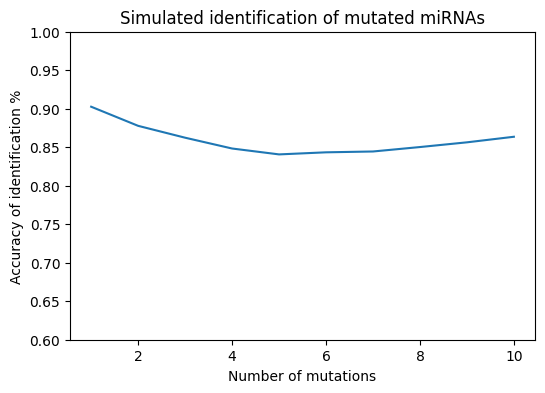

In [787]:
fig = plt.figure(figsize=(6,4))
x_arr = list(mutation_stat.index)
ax = fig.add_subplot(1,1,1)
ax.plot(x_arr, mutation_stat.acc)
ax.set_ylim(.6, 1)
ax.set_title('Simulated identification of mutated miRNAs')
ax.set_xlabel('Number of mutations')
ax.set_ylabel('Accuracy of identification %')
plt.show()

In [789]:
infile = 'unaligned_192.fa'
data_192 = MyParser().get_192_test(100)
dataset_192 = MyEmbedding(data_192).split2()
print(dataset_192[0])

p = MyProcess(model, collate_fn)
stat_192 = p.test({'192': dataset_192})
stat_192

('192', 'CCAGGCGGCCCGGGTTCGACTCCCGGTATGGGAAC')
99 <class 'torch.utils.data.dataset.Subset'>
('192', 'CCAGGCGGCCCGGGTTCGACTCCCGGTATGGGAAC')
dataset: 192, accuracy: 0.4141, loss: 9.3270, recall: 0.4141


,acc,loss,recall
192,0.414141,9.326954,0.414141


In [792]:
#predict miRNAs from 192 samples
infile = 'unaligned_192.fa'
texts_192, labels_192 = MyParser().get_192()


p = MyProcess(model, collate_fn)
acc_192, stat_192 = p.predict(texts_192, labels_192)
acc_192

0.4740231323046113

In [828]:
P=.95
sig_df = stat_192[stat_192.predict>=P]
print(sig_df.shape, stat_192.shape, f"percentage={len(sig_df)*100/len(stat_192):.2f}%")
sig_df.head()

(97508, 2) (824907, 2) percentage=11.82%


,text,predict
19,CCCTGTACTGAGCTGCCCTGA,0.990920
30,GAGAATGTCTGCAAGAACTGC,0.970547
72,TCGACTCCCGGTGTGGGAAC,0.976840
105,TCGACTCCCGGTATGGGAAC,0.960179
113,AATCATCGAATCTTTGAACG,0.969063


<>:5: DeprecationWarning: invalid escape sequence \g
<>:7: DeprecationWarning: invalid escape sequence \g
<>:5: DeprecationWarning: invalid escape sequence \g
<>:7: DeprecationWarning: invalid escape sequence \g
/tmp/ipykernel_28642/1787241048.py:5: DeprecationWarning: invalid escape sequence \g
  plt.ylabel('Number of sequences (read counts $\geq$ 3 )')
/tmp/ipykernel_28642/1787241048.py:7: DeprecationWarning: invalid escape sequence \g
  plt.text(.2, 100000, f'signficance prediction = {len(sig_df)}' + '\n' + f' (P $\geq$ {P}), percentage={per:.1f}%')


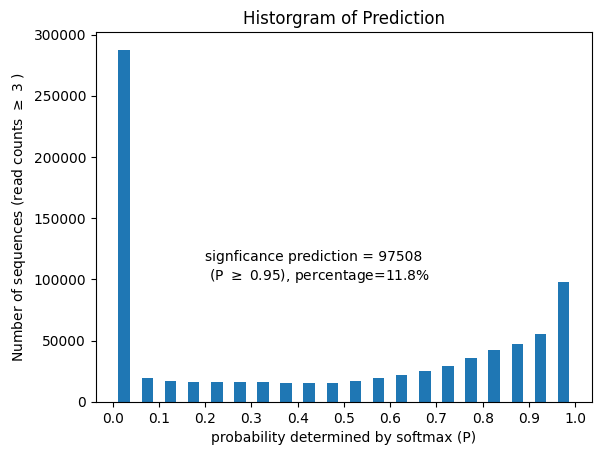

In [843]:
plt.hist(stat_192.predict, bins=20, rwidth=.5)
plt.title('Historgram of Prediction')
plt.xlabel('probability determined by softmax (P)')
plt.xticks(np.arange(0, 1.1, step=.1))
plt.ylabel('Number of sequences (read counts $\geq$ 3 )')
per = len(sig_df)*100/len(stat_192)
plt.text(.2, 100000, f'signficance prediction = {len(sig_df)}' + '\n' + f' (P $\geq$ {P}), percentage={per:.1f}%')
plt.show()

## pre-trained RNN

In [308]:
class RNN1(nn.Module):
    def __init__(self, input_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embed_dim, padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()

    def forward(self, text, lengths):
        out = self.embedding(text)
        # Packs a Tensor containing padded sequences of variable length.
        lengths = lengths.cpu().numpy()
        out = nn.utils.rnn.pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        # 
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        return out
         
vocab_size = len(input_vocab)
print(embedding_dim)
embed_dim = 24
rnn_hidden_size = 32
fc_hidden_size = 32

torch.manual_seed(1)
model1 = RNN1(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model1 = model1.to(device)

2355


In [309]:
class RNN2(nn.Module):
    def __init__(self, model1, input_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = model1.embedding
        # model: long-short term memory
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        # Packs a Tensor containing padded sequences of variable length.
        lengths = lengths.cpu().numpy()
        out = nn.utils.rnn.pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        # 
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
        
model2 = RNN2(model1, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model2 = model2.to(device)

2355


In [314]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    train(model1, train_dl, loss_fn, optimizer)
    acc_train, loss_train = train(model2, train_dl, loss_fn, optimizer)
    acc_valid, loss_valid = evaluate(model2, valid_dl, loss_fn, optimizer)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')
 

Epoch 0 accuracy: 0.8683 val_accuracy: 0.8665
Epoch 1 accuracy: 0.8683 val_accuracy: 0.8665
Epoch 2 accuracy: 0.8683 val_accuracy: 0.8665
Epoch 3 accuracy: 0.8683 val_accuracy: 0.8665
Epoch 4 accuracy: 0.8683 val_accuracy: 0.8665


In [312]:
print(model1.embedding)
model1.embedding.weight

Embedding(4928, 24, padding_idx=0)


Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1017, -0.1759, -2.2456,  ..., -1.0373,  1.5748, -0.6298],
        [-0.9274,  0.5451,  0.0663,  ..., -0.0075,  1.6734,  0.0103],
        ...,
        [-2.5470,  0.4472,  1.2326,  ..., -1.1731, -0.8936,  0.6546],
        [-1.1430, -1.4456, -1.2113,  ..., -1.2380, -0.1032,  1.8463],
        [-1.4777, -0.0540, -1.4073,  ..., -1.6092,  0.5272,  1.4486]],
       device='cuda:0', requires_grad=True)

In [313]:
print(model2.embedding)
model2.embedding.weight

Embedding(4928, 24, padding_idx=0)


Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1017, -0.1759, -2.2456,  ..., -1.0373,  1.5748, -0.6298],
        [-0.9274,  0.5451,  0.0663,  ..., -0.0075,  1.6734,  0.0103],
        ...,
        [-2.5470,  0.4472,  1.2326,  ..., -1.1731, -0.8936,  0.6546],
        [-1.1430, -1.4456, -1.2113,  ..., -1.2380, -0.1032,  1.8463],
        [-1.4777, -0.0540, -1.4073,  ..., -1.6092,  0.5272,  1.4486]],
       device='cuda:0', requires_grad=True)

In [22]:
from typing import Iterable
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

class VocabSeq:
    def __init__(self):
        self.input =  Counter()
        self.input_vocab = None
        self.label =  Counter()
        self.label_vocab = None
    
    def vocab(self, data_iter:Iterable):
        # tokenizer
        for seq_nt, labels in data_iter:
            self.input.update(seq_nt)
            self.label.update(labels)
        # encode
        self.encode_input()
        self.encode_output()
        return self.input_vocab, self.label_vocab
    
    def encode_input(self):
        ordered_input = sorted(self.input.items(), key=lambda x: x[1], reverse=True)
        ordered_input = OrderedDict(ordered_input)
        self.input_vocab = vocab(ordered_input)
        self.input_vocab.insert_token("<pad>", 0)
        self.input_vocab.insert_token("<unk>", 1)
        self.input_vocab.set_default_index(1)
    
    def encode_output(self):
        ordered_label = sorted(self.label.items(), key=lambda x: x[1], reverse=True)
        ordered_label = OrderedDict(ordered_label)
        self.label_vocab = vocab(ordered_label)
# 
coder = VocabSeq()
data_iter = iterate_data(infile)
input_vocab, label_vocab = coder.vocab(data_iter)

In [23]:
# split dataset
from torch.utils.data.dataset import random_split
data_iter = iterate_data(infile)
train_data = []
for item in data_iter:
    # input
    input_vector = [input_vocab[i] for i in item[0]]
    input_vector += [0] * (embedding_dim - len(input_vector))
    # label
    label_vector = [label_vocab[i] for i in item[1]]
    #     
    train_data.append((label_vector, input_vector))
    
num_train = round(len(train_data)*.8)
num_valid = len(train_data) - num_train
train_dataset, valid_dataset = random_split(train_data, [num_train, num_valid])

In [27]:
print(len(train_dataset), type(train_dataset))
print(train_dataset[0], len(train_dataset[0]))

39108 <class 'torch.utils.data.dataset.Subset'>
([27, 10, 3, 13, 14, 8, 7, 8, 1, 5, 15, 0, 12, 18, 2, 0, 8], [2, 4, 4, 4, 3, 5, 2, 4, 3, 4, 2, 2, 4, 5, 5, 4, 4, 4, 3, 5, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 2


In [25]:
## define the functions for transformation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    lengths = torch.tensor(lengths)
    # padding is appended to the end of token vector of each sentence
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [29]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
print(type(dataloader))

##Observe data dimensions: Take a small batch
text_batch, label_batch, length_batch = next(iter(dataloader))
print('input:', text_batch.shape)
print('output:', label_batch)
print('batch size=', length_batch)

print(text_batch)

<class 'torch.utils.data.dataloader.DataLoader'>


ValueError: expected sequence of length 17 at dim 1 (got 19)

In [28]:
## Step 4: batching the datasets. shuffle data for each epoch
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embed_dim, padding_idx=0) 
        # model: long-short term memory
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        # Packs a Tensor containing padded sequences of variable length.
        lengths = lengths.cpu().numpy()
        out = nn.utils.rnn.pack_padded_sequence(out, lengths, batch_first=True, enforce_sorted=False)
        # 
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
         
vocab_size = len(input_vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)
    

In [15]:
def train(dataloader, loss_fn, optimizer):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader, loss_fn, optimizer):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10 

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl, loss_fn, optimizer)
    acc_valid, loss_valid = evaluate(valid_dl, loss_fn, optimizer)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')
 

ValueError: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32])) is deprecated. Please ensure they have the same size.

In [ ]:

# from torch.utils.data import Dataset

# class MirnaDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         label = self.labels[idx]
#         return sample, label
# mirna_dataset = MirnaDataset(train_data, labels)
# print(mirna_dataset)